In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

/Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 1. Train Model

#### 1.1. Describe data and split dataset

In [2]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [3]:
df = describe_dataset("./train.csv")
df = pd.read_csv("./train.csv")
df.loc[df["label"] == "C", "label"] = 0
df.loc[df["label"] == "H", "label"] = 1
df.loc[df["label"] == "L", "label"] = 2
df.tail(3)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
28517,1,0.735630,0.543294,0.007467,0.999246,0.695831,0.417349,0.155194,0.995723,0.720067,...,0.086010,0.966131,0.226601,0.598075,0.219305,0.470830,0.220079,0.614120,0.026265,0.934942
28518,1,0.775572,0.517579,0.012821,0.999378,0.704168,0.404210,0.162908,0.995909,0.730823,...,0.070911,0.967070,0.238810,0.610591,0.198591,0.496140,0.228907,0.625559,0.018591,0.938905
28519,1,0.790600,0.498958,0.007789,0.999467,0.710651,0.394019,0.164441,0.996123,0.736771,...,0.085872,0.967943,0.238197,0.609329,0.233198,0.510583,0.227823,0.626068,0.036127,0.940917


In [ ]:
# Given the angle and the postions of the body parts, we need to predict the lables. 

In [5]:
# - Correct: "C"
# - Back is too low: "L"
# - Back is too high: "H"

In [4]:
# Extract features and class
X = df.drop("label", axis=1) # features
y = df["label"].astype("int") # TArget 


In [5]:
# Scale the features using standard scalar using the mean and standard deviations. 

sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test.head(3)

24916    1
4603     2
9763     2
Name: label, dtype: int64

#### 1.2. Train model using Scikit-Learn and train set evaluation

In [8]:
# Use the grid search to get the optimum hyperparameters 
# from sklearn.model_selection import GridSearchCV
# 
# # Example parameter grids for each model
# param_grids = {
#     "LR": {'C': [0.01, 0.1, 1, 10]},
#     "SVC": {'C': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']},
#     "KNN": {'n_neighbors': [3, 5, 7, 9]},
#     "DTC": {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5]},
#     "SGDC": {},
#     "NB": {},  # No hyperparameters to tune for GaussianNB
#     "RF": {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
# }
# 
# # Perform grid search on all algorithms
# best_models = {}

from sklearn.ensemble import HistGradientBoostingClassifier

algorithms =[("HistGradientBoosting", HistGradientBoostingClassifier()),
            ("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]



# for name, model in algorithms:
#     grid = GridSearchCV(estimator=model, param_grid=param_grids.get(name, {}), scoring='accuracy', cv=5, n_jobs=-1)
#     grid.fit(X_train, y_train)
#     
#     best_models[name] = grid.best_estimator_
#     print(f"Best parameters for {name}: {grid.best_params_}")


In [9]:
# algorithms =[("LR", LogisticRegression(C=10)),
#          ("SVC", SVC(probability=True)),
#          ('KNN',KNeighborsClassifier(n_neighbors=3)),
#          ("DTC", DecisionTreeClassifier(max_depth=10, min_samples_split=5)),
#          ("SGDC", CalibratedClassifierCV(SGDClassifier())),
#          ("NB", GaussianNB()),
#          ('RF', RandomForestClassifier(max_depth=None, n_estimators=100)),]

# once we have seen the algorithms hyperparameters, from the grid search we can see their performance. 

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1, 2])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1, 2])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1, 2])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))


In [10]:
# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)

pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,KNN,"[1.0, 1.0, 0.999]",0.999649,"[1.0, 1.0, 0.999]","[1.0, 1.0, 0.999]","[[2010, 0, 1], [0, 1825, 0], [1, 0, 1867]]"
1,SVC,"[0.999, 1.0, 0.999]",0.999299,"[0.999, 1.0, 0.999]","[0.999, 1.0, 0.999]","[[2009, 0, 2], [0, 1825, 0], [2, 0, 1866]]"
2,RF,"[0.999, 1.0, 0.999]",0.999299,"[1.0, 0.999, 0.999]","[0.999, 1.0, 0.999]","[[2010, 0, 1], [1, 1824, 0], [2, 0, 1866]]"
3,HistGradientBoosting,"[0.998, 1.0, 0.999]",0.998773,"[1.0, 0.998, 0.998]","[0.999, 0.999, 0.999]","[[2010, 0, 1], [2, 1822, 1], [3, 0, 1865]]"
4,LR,"[0.999, 1.0, 0.998]",0.998948,"[0.998, 1.0, 0.999]","[0.999, 1.0, 0.998]","[[2007, 0, 4], [0, 1825, 0], [2, 0, 1866]]"
5,DTC,"[0.997, 0.999, 0.997]",0.997721,"[0.997, 1.0, 0.997]","[0.997, 1.0, 0.997]","[[2004, 1, 6], [0, 1825, 0], [6, 0, 1862]]"
6,SGDC,"[0.999, 0.999, 0.996]",0.997896,"[0.996, 0.999, 0.999]","[0.997, 0.999, 0.998]","[[2002, 2, 7], [2, 1823, 0], [1, 0, 1867]]"
7,NB,"[0.837, 0.931, 0.938]",0.897966,"[0.884, 0.958, 0.854]","[0.86, 0.944, 0.894]","[[1778, 128, 105], [77, 1748, 0], [270, 2, 1596]]"


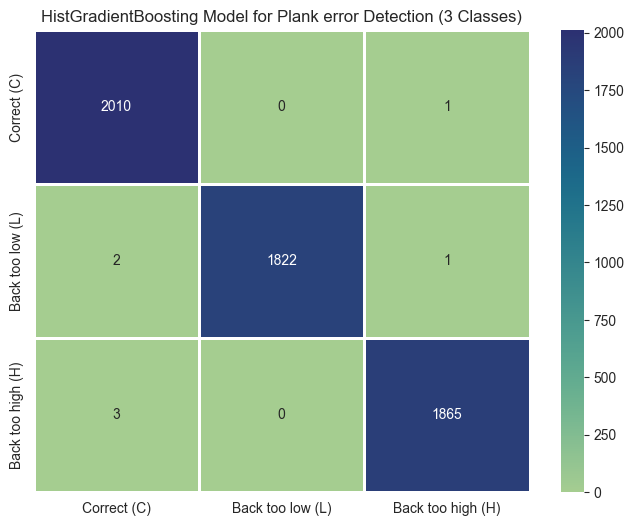

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `final_results` contains data structured as described
# Extract the confusion matrix for HistGradientBoosting
hist_gb_cm = next(item[5] for item in final_results if item[0] == "HistGradientBoosting")

# Create a DataFrame for the confusion matrix with proper labels
cm_df = pd.DataFrame(hist_gb_cm, 
                     index=["Correct (C)", "Back too low (L)", "Back too high (H)"], 
                     columns=["Correct (C)", "Back too low (L)", "Back too high (H)"])

# Plot the confusion matrix heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="crest", linewidths=1, ax=ax)

# Add title
ax.set_title("HistGradientBoosting Model for Plank error Detection (3 Classes)")

# Display the plot
plt.show()


In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

# Create a list of (name, model) tuples from trained models
voting_estimators = [(name, model) for name, model in models.items()]

# Use VotingClassifier (soft voting averages the probabilities for each class)
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')  # For probability voting

# Train the ensemble classifier
voting_clf.fit(X_train, y_train)

# Predict using the ensemble model
ensemble_predictions = voting_clf.predict(X_test)

# Evaluate the ensemble model's performance
ensemble_precision = precision_score(y_test, ensemble_predictions, average=None, labels=[0, 1, 2])
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions, average=None, labels=[0, 1, 2])
ensemble_f1_score = f1_score(y_test, ensemble_predictions, average=None, labels=[0, 1, 2])
ensemble_cm = confusion_matrix(y_test, ensemble_predictions, labels=[0, 1, 2])

# Print results
print("Ensemble Voting Classifier Results:")
print(f"Precision: {ensemble_precision}")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Recall: {ensemble_recall}")
print(f"F1 Score: {ensemble_f1_score}")
print(f"Confusion Matrix:\n {ensemble_cm}")


Ensemble Voting Classifier Results:
Precision: [0.99899295 1.         0.99948213]
Accuracy: 0.9995
Recall: [0.99949622 0.99944072 0.99948213]
F1 Score: [0.99924452 0.99972028 0.99948213]
Confusion Matrix:
 [[1984    0    1]
 [   1 1787    0]
 [   1    0 1930]]


#### 1.3. Test set evaluation

In [19]:
test_df = describe_dataset("./test.csv")
test_df = test_df.sample(frac=1).reset_index(drop=True)

test_df.loc[test_df["label"] == "C", "label"] = 0
test_df.loc[test_df["label"] == "H", "label"] = 1
test_df.loc[test_df["label"] == "L", "label"] = 2

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")

test_x = pd.DataFrame(sc.transform(test_x))


model_results = voting_clf.predict(test_x)

p_score = precision_score(test_y, model_results, average=None, labels=[0, 1, 2])
a_score = accuracy_score(test_y, model_results)
r_score = recall_score(test_y, model_results, average=None, labels=[0, 1, 2])
f1_score_result = f1_score(test_y, model_results, average=None, labels=[0, 1, 2])
cm = confusion_matrix(test_y, model_results, labels=[0, 1, 2])

testset_final_results = []

testset_final_results.append(( "VOTER",  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm ))

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

In [20]:
testset_final_results

[('VOTER',
  [0.979, 1.0, 0.996],
  0.9915492957746479,
  [1.0, 0.992, 0.983],
  [0.989, 0.996, 0.989],
  array([[234,   0,   0],
         [  1, 239,   1],
         [  4,   0, 231]]))]

In [13]:
test_df = describe_dataset("./test.csv")
test_df = test_df.sample(frac=1).reset_index(drop=True)

test_df.loc[test_df["label"] == "C", "label"] = 0
test_df.loc[test_df["label"] == "H", "label"] = 1
test_df.loc[test_df["label"] == "L", "label"] = 2

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")

test_x = pd.DataFrame(sc.transform(test_x))


model_results = models["HistGradientBoosting"].predict(test_x)

p_score = precision_score(test_y, model_results, average=None, labels=[0, 1, 2])
a_score = accuracy_score(test_y, model_results)
r_score = recall_score(test_y, model_results, average=None, labels=[0, 1, 2])
f1_score_result = f1_score(test_y, model_results, average=None, labels=[0, 1, 2])
cm = confusion_matrix(test_y, model_results, labels=[0, 1, 2])

testset_final_results = []

testset_final_results.append(( "HistGradientBoosting",  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm ))

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

In [14]:
testset_final_results

[('HistGradientBoosting',
  [0.976, 1.0, 0.85],
  0.9352112676056338,
  [0.868, 0.95, 0.987],
  [0.919, 0.974, 0.913],
  array([[203,   0,  31],
         [  2, 229,  10],
         [  3,   0, 232]]))]

In [ ]:
# We can see that the voter is performing very good. 

#### 1.4. Dumped model and input scaler using pickle

According to the evaluations, there are multiple good models at the moment, therefore, the best models are LR and Ridge.

In [23]:
with open("./model/all_sklearn_jainil.pkl", "wb") as f:
    pickle.dump(models, f)

In [24]:
with open("./model/LR_model_jainil.pkl", "wb") as f:
    pickle.dump(models["LR"], f)

In [25]:
with open("./model/SVC_model_jainil.pkl", "wb") as f:
    pickle.dump(models["SVC"], f)

In [26]:
# Dump input scaler
with open("./model/input_scaler_jainil.pkl", "wb") as f:
    pickle.dump(sc, f)

In [27]:
# Dump input scaler
with open("./model/voter.pkl", "wb") as f:
    pickle.dump(voting_clf, f)